In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import flopy

flopy is installed in /Users/shua784/anaconda3/lib/python3.6/site-packages/flopy


In [2]:
%matplotlib inline
# plt.rcParams['figure.figsize'] = [6, 5]
plt.rcParams['figure.dpi'] = 100

Command to use to update flopy:

```conda install flopy```

Command to download executables (i.e. modflow2015) 

```python ../bin/download_executables.py```

### Conceptual model

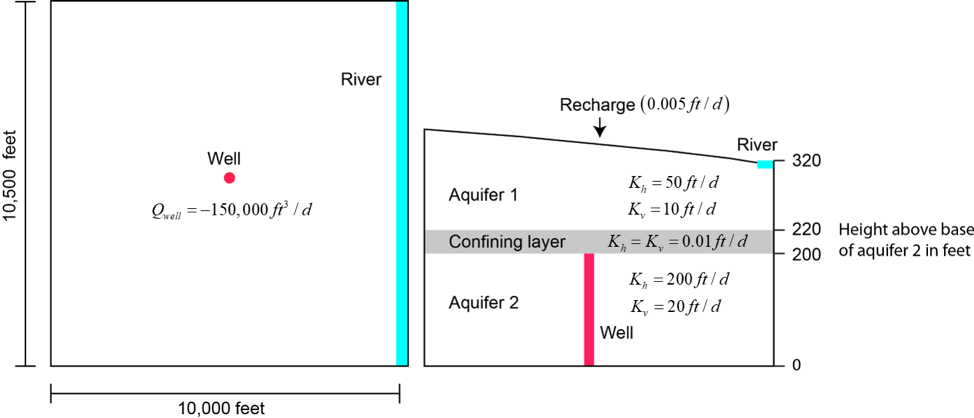

### Building and post-processing a MODFLOW-2005 model

A MODFLOW-2005 model will be developed of the domain shown above. This model simulation is based on example 1 in [Pollock, D.W., 2016, User guide for MODPATH Version 7—A particle-tracking model for MODFLOW: U.S. Geological Survey Open-File Report 2016–1086, 35 p., http://dx.doi.org/10.3133/ofr20161086](https://doi.org/10.3133/ofr20161086).

The model domain will be discretized into 3 layers, 21 rows, and 20 columns. A constant value of 500. will `delr` and `delc`. The top of the model should be set to 400 and the bottom of the three layers should be set to 220, 200, and 0. The model has one steady-state stress period. 

Create a model object using `flopy.modflow.Modflow()` and then create the discretization package using `flopy.modflow.ModflowDis()`. Before creating the model object you should define the model workspace (`model_ws`) where the model files are, the model name (`name`), and the name and path of the model executable (`exe_name`).  The `model_ws` should be set to `'data/ex01a'`, `name` should be set to `ex01a`, and `exe_name` should be set to `bin/mf2005`.

In [3]:
# os.chdir('/Users/shua784/Dropbox/Conferences_and_Meetings/Modflow_2019/Flopy_course/MM2019_FloPy/Notebooks')

In [4]:
ws = '../data/ex01a'
name = 'ex01a'
exe_name = os.path.abspath('../bin/mf2005')

In [5]:
m  = flopy.modflow.Modflow(exe_name=exe_name, model_ws=ws, name = name)

In [6]:
nlay, nrow, ncol = 3, 21, 20
delr= delc = 500
top = 400 # top elevation
botm = [220, 200, 0] # elevation for bottom of three layers

In [7]:
dis = flopy.modflow.ModflowDis(m,  nlay=nlay, nrow=nrow, ncol=ncol, top=top, 
                               botm=botm, delr=delr, delc=delc)

`flopy.plot.PlotMapView()` and `flopy.plot.PlotCrossSection()` can be used to confirm that the discretization is correctly defined.

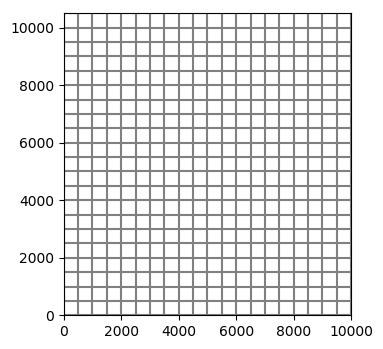

In [8]:
mm = flopy.plot.PlotMapView(model=m)
mm.plot_grid()

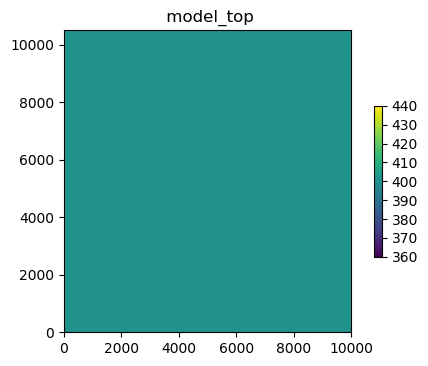

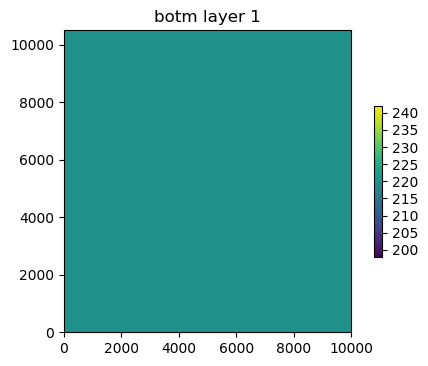

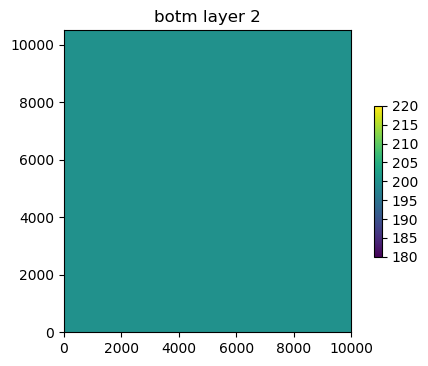

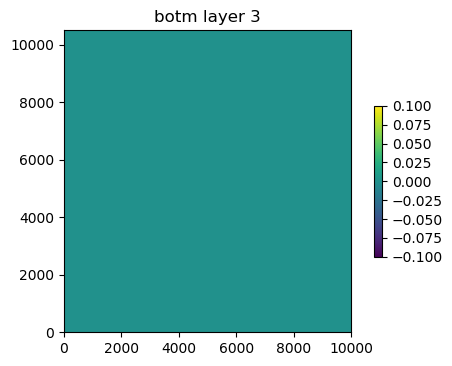

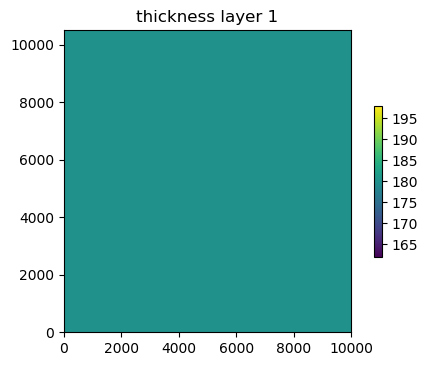

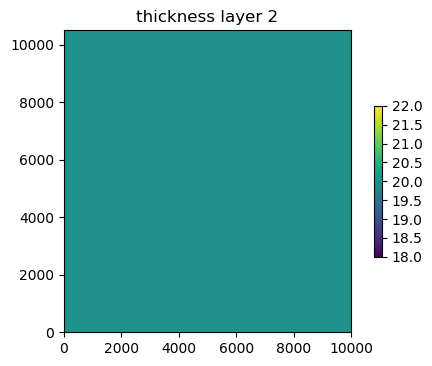

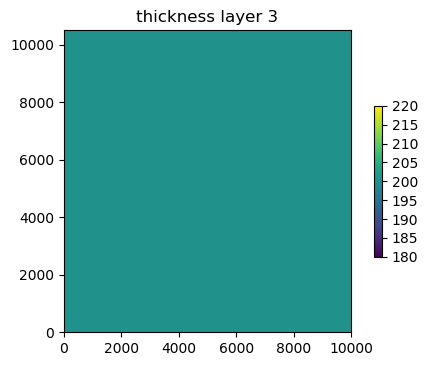

In [9]:
dis.plot()

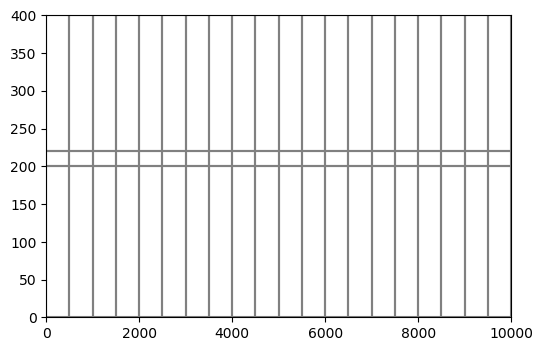

In [10]:
xs = flopy.plot.PlotCrossSection(model=m, line={'row': 10})
xs.plot_grid()

#### Create the basic (BAS) package

Set the initial head at 320. Default values can be used for the rest of the basic package input.

In [11]:
bas = flopy.modflow.ModflowBas(m, strt=320)

#### Create the layer property flow (LPF) package

The hydraulic properties for the model are defined in the image above. The first layer should be convertible (unconfined) and the remaining two layers will be non-convertible so `laytyp` should be `[1, 0, 0]`.

In [12]:
kh = [50, 0.01, 200]  # ft/day
kv = [10, 0.01, 20]
laytyp = [1, 0, 0] # layer type

In [13]:
lpf = flopy.modflow.ModflowLpf(m, laytyp=laytyp, hk=kh, vka=kv)

#### Create the recharge package

The recharge rate is defined in the image above. unit: ft/d

In [14]:
rch = flopy.modflow.ModflowRch(m, rech=0.005) 

#### Create the well package

The well is located in layer 3, row 11, column 10. The pumping rate is defined in the image above.

In [15]:
 # pumping rate unit: ft^3/d, 0 is stress period, [well_layer, well_row, well_col, pumping rate]
wel_spd = {0: [[2, 10, 9, -150000]]}
wel = flopy.modflow.ModflowWel(m, stress_period_data=wel_spd)

#### Create the river package

The river is located in layer 1 and column 20 in every row in the model. The river stage stage and bottom are at 320 and 318, respectively; the river conductance is 1e5.

In [16]:
# riv_spd [layer#, row_i, col#, rivertop, conductance, river_bottom]
riv_spd = {0: [[0, i, 19, 320, 1e5, 318] for i in range(nrow)]}
riv_spd

{0: [[0, 0, 19, 320, 100000.0, 318],
  [0, 1, 19, 320, 100000.0, 318],
  [0, 2, 19, 320, 100000.0, 318],
  [0, 3, 19, 320, 100000.0, 318],
  [0, 4, 19, 320, 100000.0, 318],
  [0, 5, 19, 320, 100000.0, 318],
  [0, 6, 19, 320, 100000.0, 318],
  [0, 7, 19, 320, 100000.0, 318],
  [0, 8, 19, 320, 100000.0, 318],
  [0, 9, 19, 320, 100000.0, 318],
  [0, 10, 19, 320, 100000.0, 318],
  [0, 11, 19, 320, 100000.0, 318],
  [0, 12, 19, 320, 100000.0, 318],
  [0, 13, 19, 320, 100000.0, 318],
  [0, 14, 19, 320, 100000.0, 318],
  [0, 15, 19, 320, 100000.0, 318],
  [0, 16, 19, 320, 100000.0, 318],
  [0, 17, 19, 320, 100000.0, 318],
  [0, 18, 19, 320, 100000.0, 318],
  [0, 19, 19, 320, 100000.0, 318],
  [0, 20, 19, 320, 100000.0, 318]]}

In [17]:
riv = flopy.modflow.ModflowRiv(m, stress_period_data=riv_spd)

#### Add the PCG solver package

Set rclose to 0.1 and use default values for the PCG package variables.

In [18]:
pcg = flopy.modflow.ModflowPcg(m, rclose=0.1) # set tolerance

#### Build output control

Define the output control for the model and set `stress_period_data` to `{(0, 0): ['save head', 'save budget']}` to save the head and flow for the model. Because we haven't set `ipakcb` to save flows for the packages we can use the `.reset_budgetunit()` method on the oc object to set the `ipakcb` for all packages that can save flows; set `budgetunit` to 131.

In [19]:
oc = flopy.modflow.ModflowOc(m, 
                             stress_period_data={(0, 0): ['save head', 'save budget']})

In [20]:
oc.reset_budgetunit(budgetunit=131) # get cell by cell output

#### Write the model files and run the model

In [21]:
m.write_input()
m.run_model()

Exception: The program /Users/shua784/Dropbox/Conferences_and_Meetings/Modflow_2019/Flopy_course/MM2019_FloPy/bin/mf2005 does not exist or is not executable.

#### Post-process the results

Load the heads and face flows from the hds and cbc files. The head file can be loaded with the `flopy.utils.HeadFile()` method. The cell-by-cell file can be loaded with the `flopy.utils.CellBudgetFile()` method.

In [ ]:
fpth = os.path.join(ws, 'modflowtest.hds')
hobj = flopy.utils.HeadFile(fpth)

In [ ]:
hds = hobj.get_data()

In [ ]:
fpth = os.path.join(ws, 'modflowtest.cbc')
cobj = flopy.utils.CellBudgetFile(fpth)

The entries in the cell-by-cell file can be determined with the `.list_unique_records()` method on the cell budget file object.

In [ ]:
cobj.list_unique_records()

Retrieve the `'FLOW RIGHT FACE'` and `'FLOW FRONT FACE'` data types from the cell-by-cell file.

In [ ]:
frf = cobj.get_data(text='FLOW RIGHT FACE')[0]
fff = cobj.get_data(text='FLOW Front FACE')[0]

#### Plot the results

Plot the results using `flopy.plot.PlotMapView()`. The head results can be plotted using the `.plot_array()` method. The discharge results can be plotted using the `plot_discharge()` method. Boundary conditions can be plotted using the `.plot_bc()` method.

In [ ]:
mm = flopy.plot.PlotMapView(model=m, layer=2)
mm.plot_grid()
v = mm.plot_array(hds) # plot head distribution
mm.plot_discharge(frf=frf, fff=fff) # add flow vectors
mm.plot_bc('RIV')
mm.plot_bc('WEL')
c = mm.contour_array(hds, colors = 'w')
plt.clabel(c)
plt.colorbar(v)